In [1]:
import shutil
import urllib.request

import numpy as np
import scipy.io
import scipy.fft
import scipy.signal
import matplotlib.pyplot as plt

message_url = "https://github.com/wunderdogsw/wundernut-vol11/raw/main/message.wav"
wav_path = "message.wav"

with urllib.request.urlopen(message_url) as response, open(wav_path, "wb") as local_file:
    shutil.copyfileobj(response, local_file)

samplerate, data = scipy.io.wavfile.read(wav_path)

/tmp/ipykernel_41334/1803008393.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = scipy.io.wavfile.read(wav_path)


## First look

Let's look at the frequency content for the whole file:

Text(0.5, 0, 'Frequency /Hz')

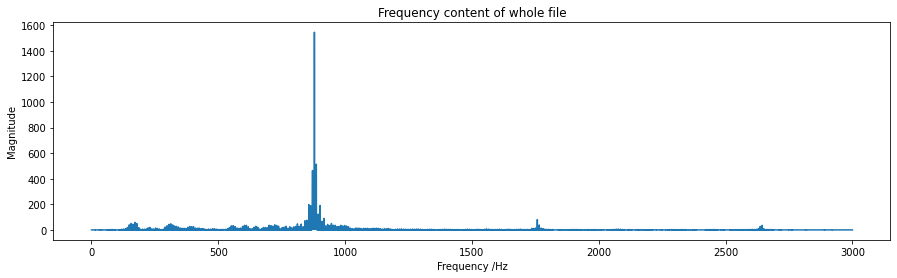

In [2]:
time = np.arange(len(data)) / samplerate

yf = 2.0 / len(data) * np.abs(scipy.fft.fft(data)[:len(data)//2])
xf = scipy.fft.fftfreq(len(data), 1/samplerate)[:len(data)//2]

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(xf[xf < 3000], yf[xf < 3000])
ax.set_title("Frequency content of whole file")
ax.set_ylabel("Magnitude")
ax.set_xlabel("Frequency /Hz")

There is one dominant frequency, as expected.

Then, let's look at the waveform

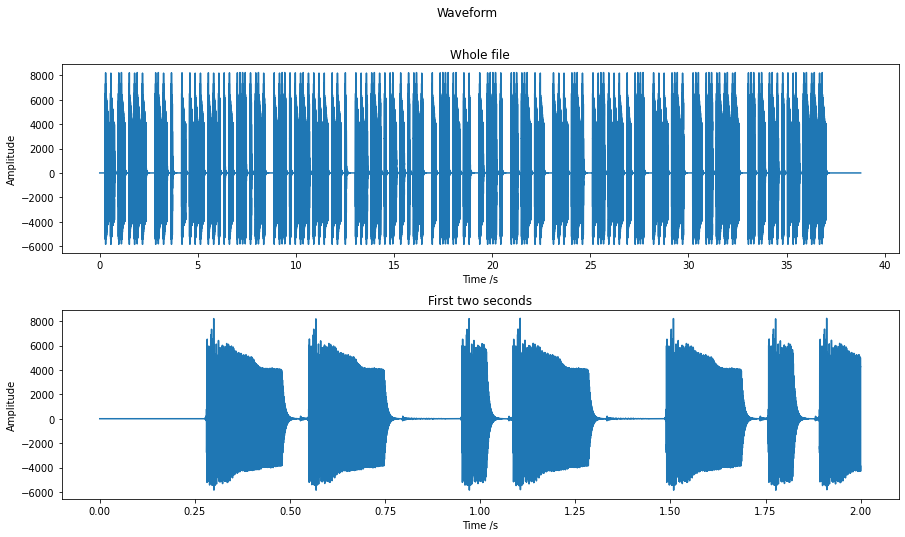

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
plt.subplots_adjust(hspace=0.3)

axes[0].plot(time, data)
axes[1].plot(time[:samplerate*2], data[:samplerate*2])

fig.suptitle("Waveform")
axes[0].set_title("Whole file")
axes[1].set_title("First two seconds")

for ax in axes:
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time /s")



Quite nice and even. The dashes and dots are quite clear. Signal is decaying, thus amplitude is not constant over the whole note length.

## Conversion to square wave

Next, let's try to convert the raw audio input to positive signal envelope. Then we will apply filtering over the envelope to make it smoother, and finally applying threshold to produce square wave 

Text(0.5, 1.0, 'Squared signal, threshold = 0.5 * max(filtered)')

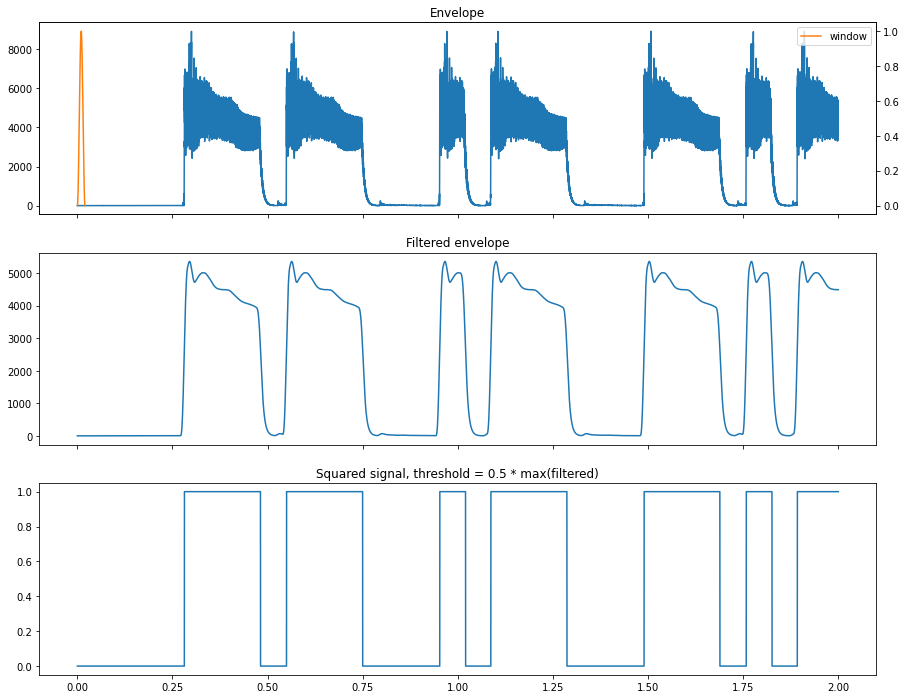

In [4]:
window_length = 0.02
threshold = 0.5

envelope = np.abs(scipy.signal.hilbert(data))
window = scipy.signal.windows.hann(int(samplerate*window_length))
filtered = scipy.signal.convolve(envelope, window, mode="same") / sum(window)

square_wave = np.where(filtered > max(filtered)*threshold, 1, 0)
square_diff = np.diff(square_wave)


fig, axes = plt.subplots(3, 1, figsize=(15,12), sharex=True)
axes[0].plot(time[:samplerate*2], envelope[:samplerate*2])
axes[0].set_title("Envelope")

ax2 = axes[0].twinx()
ax2.plot(time[:len(window)], window, color="C1", label="window")
ax2.legend()

axes[1].plot(time[:samplerate*2], filtered[:samplerate*2])
axes[1].set_title("Filtered envelope")

axes[2].plot(time[:samplerate*2], square_wave[:samplerate*2])
axes[2].set_title(f"Squared signal, threshold = {threshold} * max(filtered)")


Let's plot the original signal and square wave into same image, to see that they really are set up properly

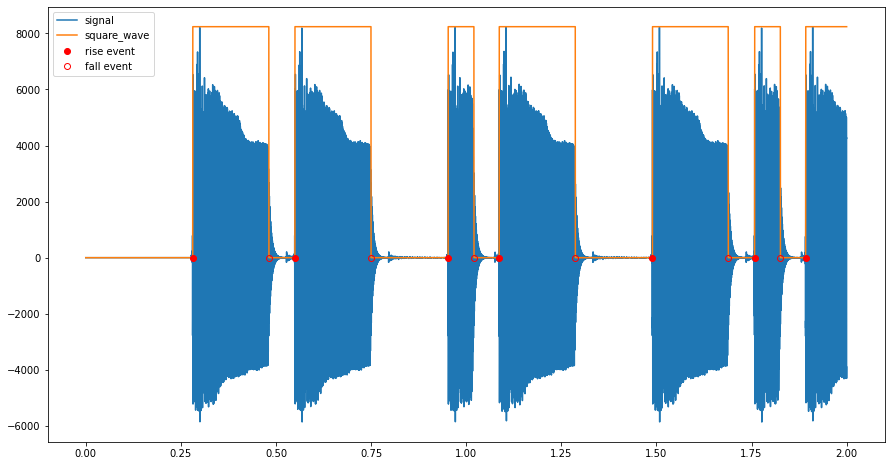

In [5]:
rising_idx = np.nonzero(square_diff == 1)[0]
falling_idx = np.nonzero(square_diff == -1)[0]

rise_times = time[rising_idx]
fall_times = time[falling_idx]


fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time[:samplerate*2], data[:samplerate*2], label="signal")

ax.plot(time[:samplerate*2], square_wave[:samplerate*2]*max(data), label="square_wave")

ax.plot(rise_times[rise_times<2], np.zeros(sum(rise_times<2)), "ro", label="rise event")
ax.plot(fall_times[fall_times<2], np.zeros(sum(fall_times<2)), "ro", fillstyle="none", label="fall event")

ax.legend()
# ax.plot(fall_times[fall_times<2], np.zeros(np.sum(fall_times<2)), "ro")

## Dash/dot separation

Next we will have a look at signal lengths.

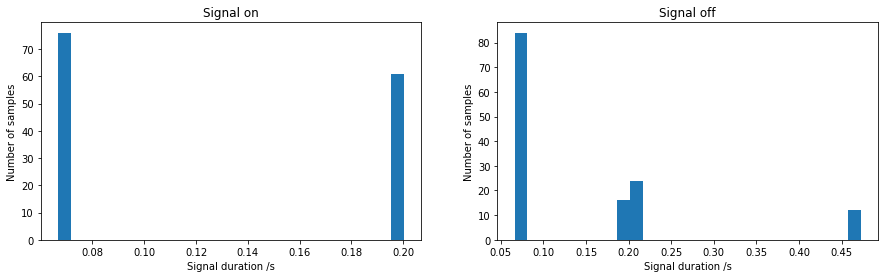

In [6]:
on_times = (falling_idx - rising_idx) / samplerate
off_times = (rising_idx[1:] - falling_idx[:len(falling_idx)-1]) / samplerate

fig, axes = plt.subplots(1,2, figsize=(15, 4))
axes[0].hist(on_times, bins=len(on_times)//5)
axes[0].set_title("Signal on")

axes[1].hist(off_times, bins=len(off_times)//5)
axes[1].set_title("Signal off")

for ax in axes:
    ax.set_ylabel("Number of samples")
    ax.set_xlabel("Signal duration /s")

As expected, there are two distinct signal ON durations (dot and dash), and three OFF durations (inter-character space, character space and word space). More values could exist if signals were noisy and code imperfect.

We will form two clusters for ON signals and three for OFF signals.

In [7]:
from sklearn.cluster import KMeans

X_on = on_times.reshape(-1, 1)
clustering_signal_on = KMeans(n_clusters=2, random_state=0).fit(X_on)

X_off = off_times.reshape(-1, 1)
clustering_signal_off = KMeans(n_clusters=3, random_state=0).fit(X_off)

dot_length = np.min(clustering_signal_on.cluster_centers_)

print(dot_length)

for header, clustering, X in [
        ("ON", clustering_signal_on, X_on),
        ("OFF", clustering_signal_off, X_off)
    ]:
    print(f'Signal {header}')
    print("Cluster centers: ", clustering.cluster_centers_.flatten())
    print("Cluster centers relative to dot length: ", clustering.cluster_centers_.flatten() / dot_length)
    print("Sum of squared distances of samples to their closest cluster center: ", clustering.inertia_)
    print()


0.06739736245375347
Signal ON
Cluster centers:  [0.06739736 0.19961526]
Cluster centers relative to dot length:  [1.         2.96176658]
Sum of squared distances of samples to their closest cluster center:  2.1681877301459138e-05

Signal OFF
Cluster centers:  [0.0677354  0.4700907  0.20220578]
Cluster centers relative to dot length:  [1.00501553 6.97491246 3.0002032 ]
Sum of squared distances of samples to their closest cluster center:  0.00015827023437961



It appears that following lengths are found:

- dot length ~ 1
- dash length ~ 3
- inter-character space ~ 1
- character space ~ 3
- word space ~ 7

It is as expected, see e.g. https://revivethis.org/sample-pack-morse-code/


### Character/word boundary separation

Get indexes for character / word spacing

In [8]:
signal_off_order = np.argsort(clustering_signal_off.cluster_centers_.flatten())
intra_space_cluster = np.where(signal_off_order == 0)[0][0]
char_space_cluster = np.where(signal_off_order == 1)[0][0]
word_space_cluster = np.where(signal_off_order == 2)[0][0]

# This index breaks dashes/dots into characters
any_space_idx = np.nonzero(clustering_signal_off.labels_ != intra_space_cluster)[0]

char_or_word_space_arr = clustering_signal_off.labels_[clustering_signal_off.labels_ != intra_space_cluster]

# This index breaks words
word_space_idx = np.nonzero(char_or_word_space_arr == word_space_cluster)[0]

In [9]:
signal_on_order = np.argsort(clustering_signal_on.cluster_centers_.flatten())
dot_cluster = np.where(signal_on_order == 0)[0][0]
dash_cluster = np.where(signal_on_order == 1)[0][0]

dash_dot_map = {dot_cluster: '.', dash_cluster: '-'}
dash_dot_characters = np.vectorize(dash_dot_map.get)(clustering_signal_on.labels_)
dash_dot_characters

array(['-', '-', '.', '-', '-', '.', '-', '-', '.', '-', '-', '.', '-',
       '-', '-', '-', '-', '-', '.', '.', '-', '.', '.', '.', '.', '.',
       '.', '-', '.', '-', '.', '.', '.', '.', '-', '.', '-', '.', '-',
       '-', '-', '-', '-', '.', '-', '-', '.', '.', '-', '.', '.', '.',
       '-', '-', '.', '.', '-', '.', '-', '.', '.', '.', '.', '.', '-',
       '-', '.', '-', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
       '-', '-', '-', '-', '-', '-', '.', '.', '-', '.', '-', '.', '.',
       '.', '-', '-', '-', '-', '.', '.', '.', '.', '-', '-', '-', '.',
       '.', '-', '.', '.', '.', '-', '.', '.', '.', '.', '-', '.', '-',
       '.', '-', '.', '.', '.', '.', '-', '.', '-', '.', '.', '-', '.',
       '-', '.', '-', '.', '-', '.', '-'], dtype='<U1')

## Characters and words

In [10]:
char_start_idx = [0] + (any_space_idx + 1).tolist()
char_end_idx = (any_space_idx + 1).tolist() + [len(dash_dot_characters)]
morse_characters = ["".join(dash_dot_characters[i:j]) for i, j in zip(char_start_idx, char_end_idx)]

word_start_idx = [0] + (word_space_idx + 1).tolist()
word_end_idx = (word_space_idx + 1).tolist() + [len(morse_characters)]
morse_words = [morse_characters[i:j] for i, j in zip(word_start_idx, word_end_idx)]

morse_words

[['--', '.-', '-.--'],
 ['.--', '.'],
 ['-', '---', '--.', '.', '-', '....', '.', '.-.'],
 ['-...', '.', '-.-.', '---', '--', '.'],
 ['--.', '.-.', '.', '.-', '-', '.', '.-.'],
 ['-', '....', '.-', '-.'],
 ['-', '....', '.'],
 ['...', '..-', '--'],
 ['---', '..-.'],
 ['-...', '---', '-', '....'],
 ['---', '..-.'],
 ['..-', '...', '.-.-.-'],
 ['...', '.-', '.-.', '.', '-.-', '.-.-.-']]

## Translation to natural language

In [11]:
char_to_morse = {
    "0":"-----",
    "1":".----",
    "2":"..---",
    "3":"...--",
    "4":"....-",
    "5":".....",
    "6":"-....",
    "7":"--...",
    "8":"---..",
    "9":"----.",
    "A":".-",
    "B":"-...",
    "C":"-.-.",
    "D":"-..",
    "E":".",
    "F":"..-.",
    "G":"--.",
    "H":"....",
    "I":"..",
    "J":".---",
    "K":"-.-",
    "L":".-..",
    "M":"--",
    "N":"-.",
    "O":"---",
    "P":".--.",
    "Q":"--.-",
    "R":".-.",
    "S":"...",
    "T":"-",
    "U":"..-",
    "V":"...-",
    "W":".--",
    "X":"-..-",
    "Y":"-.--",
    "Z":"--..",
    ".":".-.-.-",
}

morse_to_chars = {v: k for k, v in char_to_morse.items()}

letters = list(map(morse_to_chars.get, morse_characters))
words = [letters[i:j] for i, j in zip(word_start_idx, word_end_idx)]


print(" ".join(["".join(word) for word in words]))

MAY WE TOGETHER BECOME GREATER THAN THE SUM OF BOTH OF US. SAREK.
